<a href="https://colab.research.google.com/github/AnaHristian/deep_learning_pytorch/blob/master/challenge/Image_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
mv flower_data/test flower_data/valid

In [4]:
! wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip

--2018-12-18 13:26:19--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.109.205
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.109.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘flower_data.zip’

flower_data.zip     100%[===================>] 297.01M  36.7MB/s    in 8.7s    

2018-12-18 13:26:28 (34.2 MB/s) - ‘flower_data.zip’ saved [311442766/311442766]



In [45]:
! wget https://github.com/cahya-wirawan/Udacity-Course/blob/master/flower_test.tgz

--2018-12-18 15:44:50--  https://github.com/cahya-wirawan/Udacity-Course/blob/master/flower_test.tgz
Resolving github.com (github.com)... 140.82.118.3, 140.82.118.4
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘flower_test.tgz’

flower_test.tgz         [ <=>                ]  53.78K  --.-KB/s    in 0.009s  

2018-12-18 15:44:51 (5.93 MB/s) - ‘flower_test.tgz’ saved [55073]



In [50]:
!tar -xvzf flower_test.tgz


gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now


In [0]:
!unzip flower_data.zip

In [51]:
!unzip test.zip

Archive:  test.zip
   creating: test/
   creating: test/1/
  inflating: test/1/image_06743.jpg  
  inflating: test/1/image_06752.jpg  
  inflating: test/1/image_06754.jpg  
  inflating: test/1/image_06760.jpg  
  inflating: test/1/image_06764.jpg  
   creating: test/10/
  inflating: test/10/image_07090.jpg  
  inflating: test/10/image_07104.jpg  
  inflating: test/10/image_07117.jpg  
   creating: test/100/
  inflating: test/100/image_07896.jpg  
  inflating: test/100/image_07897.jpg  
  inflating: test/100/image_07899.jpg  
  inflating: test/100/image_07902.jpg  
  inflating: test/100/image_07926.jpg  
  inflating: test/100/image_07936.jpg  
  inflating: test/100/image_07938.jpg  
  inflating: test/100/image_07939.jpg  
   creating: test/101/
  inflating: test/101/image_07949.jpg  
  inflating: test/101/image_07952.jpg  
  inflating: test/101/image_07983.jpg  
  inflating: test/101/image_07988.jpg  
   creating: test/102/
  inflating: test/102/image_08004.jpg  
  inflating: test/102/i

In [0]:
!mv test flower_data\

In [0]:
# Import necessary packages
import matplotlib.pyplot as plt
import numpy as np

# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

#from scipy import sparse
import view_helper as helper

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). 
The dataset is split into two parts
1. Training:
  -  Apply transformations such as **random scaling, cropping, and flipping**
    - This will help the network generalize leading to better performance. 
  - If you use a pre-trained network, you'll also need to make sure the input data is resized to `224x224` pixels as required by the networks.
2. Validation. 
  - The validation set is used to measure the model's performance on data it hasn't seen yet. 
  - For this you don't want any scaling or rotation transformations, but you'll need to **resize then crop the images to the appropriate size**.

The pre-trained networks available from `torchvision` were trained on the **ImageNet** dataset where each color channel was normalized separately. 
- For both sets you'll need to **normalize** the means and standard deviations of the images to what the network expects. 
- For the **means**, it's `[0.485, 0.456, 0.406]` 
- and for the **standard deviations** `[0.229, 0.224, 0.225]`, calculated from the ImageNet images. 
- These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [9]:
!pip install Pillow==5.3.0
!pip install PIL
!pip install image
from PIL import Image

  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [10]:
!pip install -U pillow

Requirement already up-to-date: pillow in /usr/local/lib/python3.6/dist-packages (5.3.0)


In [0]:
import PIL

In [0]:
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#   for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
# TODO: Define your transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=valid_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=valid_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [5]:
len(train_data), len(valid_data)

(6552, 818)

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

<class 'torch.Tensor'>
77 passion flower
82 clematis
67 spring crocus
51 petunia


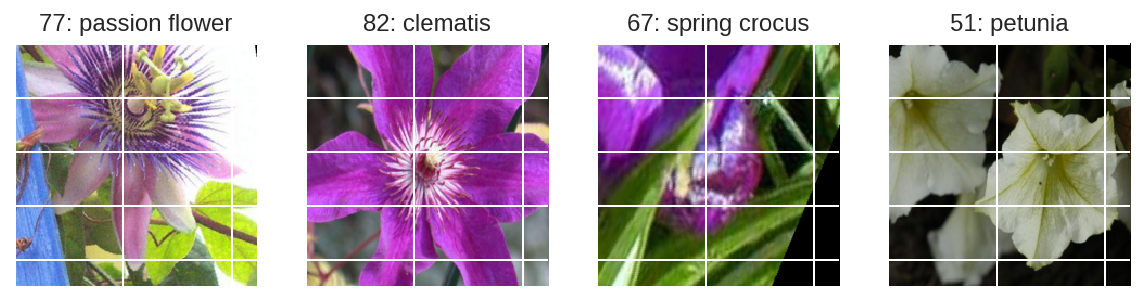

In [59]:
# change this to the trainloader or validloader 
data_iter = iter(trainloader)

images, labels = next(data_iter)
print(type(labels))

# map the labels
new_labels = []
for i in range(len(labels)):
  new_labels.append(int(train_data.classes[labels[i].item()]))
new_labels = torch.tensor(new_labels)
#labels = new_labels
#print(type(labels))
  
fig, axes = plt.subplots(figsize=(10,10), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=True)
    print(new_labels[ii].item(), cat_to_name[str(new_labels[ii].item())])
    ax.set_title("{}: {}".format(new_labels[ii].item(), cat_to_name[str(new_labels[ii].item())]))

In [8]:
labels[:10]

tensor([56, 74, 60, 77, 18, 84, 48, 97, 14, 36])

In [9]:
new_labels[:10]

tensor([58, 74, 61, 77, 23, 83, 50, 95,  2,  4])

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [10]:
cat_to_name['54']

'sunflower'

In [11]:
new_labels = []
for i in range(len(labels)):
  new_labels.append(int(train_data.classes[labels[i].item()]))
  print("labels: {} actual label: {} name: {}".format(labels[i].item(), train_data.classes[labels[i].item()], cat_to_name[train_data.classes[labels[i].item()]]))

labels: 56 actual label: 58 name: geranium
labels: 74 actual label: 74 name: rose
labels: 60 actual label: 61 name: cautleya spicata
labels: 77 actual label: 77 name: passion flower
labels: 18 actual label: 23 name: fritillary
labels: 84 actual label: 83 name: hibiscus
labels: 48 actual label: 50 name: common dandelion
labels: 97 actual label: 95 name: bougainvillea
labels: 14 actual label: 2 name: hard-leaved pocket orchid
labels: 36 actual label: 4 name: sweet pea
labels: 57 actual label: 59 name: orange dahlia
labels: 7 actual label: 13 name: king protea
labels: 100 actual label: 98 name: mexican petunia
labels: 97 actual label: 95 name: bougainvillea
labels: 49 actual label: 51 name: petunia
labels: 89 actual label: 88 name: cyclamen
labels: 23 actual label: 28 name: stemless gentian
labels: 51 actual label: 53 name: primula
labels: 49 actual label: 51 name: petunia
labels: 43 actual label: 46 name: wallflower
labels: 100 actual label: 98 name: mexican petunia
labels: 59 actual lab

In [12]:
labels

tensor([ 56,  74,  60,  77,  18,  84,  48,  97,  14,  36,  57,   7, 100,  97,
         49,  89,  23,  51,  49,  43, 100,  59,  74,  90,  96,  18,  43,  47,
         43,  99, 100,  71,  32,  47,  59,  70,  27,  17,  91,   1,  24,  81,
         83,  77,  21,  57,  84,  74,  37,  62,  96,  88,  90,   2,  88,  80,
         17,  44,  59,  43,  34,  77,  73,  98])

In [13]:
new_labels = torch.tensor(new_labels)
new_labels[:10]

tensor([58, 74, 61, 77, 23, 83, 50, 95,  2,  4])

In [14]:
{str(new_labels[i].item()): cat_to_name[str(new_labels[i].item())] for i in range(len(new_labels))}

{'10': 'globe thistle',
 '100': 'blanket flower',
 '13': 'king protea',
 '2': 'hard-leaved pocket orchid',
 '22': 'pincushion flower',
 '23': 'fritillary',
 '26': 'corn poppy',
 '28': 'stemless gentian',
 '29': 'artichoke',
 '31': 'carnation',
 '36': 'ruby-lipped cattleya',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '40': 'lenten rose',
 '46': 'wallflower',
 '47': 'marigold',
 '5': 'english marigold',
 '50': 'common dandelion',
 '51': 'petunia',
 '53': 'primula',
 '58': 'geranium',
 '59': 'orange dahlia',
 '60': 'pink-yellow dahlia',
 '61': 'cautleya spicata',
 '63': 'black-eyed susan',
 '70': 'tree poppy',
 '71': 'gazania',
 '73': 'water lily',
 '74': 'rose',
 '77': 'passion flower',
 '8': 'bird of paradise',
 '80': 'anthurium',
 '82': 'clematis',
 '83': 'hibiscus',
 '87': 'magnolia',
 '88': 'cyclamen',
 '89': 'watercress',
 '9': 'monkshood',
 '94': 'foxglove',
 '95': 'bougainvillea',
 '96': 'camellia',
 '97': 'mallow',
 '98': 'mexican petunia'}

In [15]:
train_data.classes[:10]

['1', '10', '100', '101', '102', '11', '12', '13', '14', '15']

In [16]:
train_data.class_to_idx

{'1': 0,
 '10': 1,
 '100': 2,
 '101': 3,
 '102': 4,
 '11': 5,
 '12': 6,
 '13': 7,
 '14': 8,
 '15': 9,
 '16': 10,
 '17': 11,
 '18': 12,
 '19': 13,
 '2': 14,
 '20': 15,
 '21': 16,
 '22': 17,
 '23': 18,
 '24': 19,
 '25': 20,
 '26': 21,
 '27': 22,
 '28': 23,
 '29': 24,
 '3': 25,
 '30': 26,
 '31': 27,
 '32': 28,
 '33': 29,
 '34': 30,
 '35': 31,
 '36': 32,
 '37': 33,
 '38': 34,
 '39': 35,
 '4': 36,
 '40': 37,
 '41': 38,
 '42': 39,
 '43': 40,
 '44': 41,
 '45': 42,
 '46': 43,
 '47': 44,
 '48': 45,
 '49': 46,
 '5': 47,
 '50': 48,
 '51': 49,
 '52': 50,
 '53': 51,
 '54': 52,
 '55': 53,
 '56': 54,
 '57': 55,
 '58': 56,
 '59': 57,
 '6': 58,
 '60': 59,
 '61': 60,
 '62': 61,
 '63': 62,
 '64': 63,
 '65': 64,
 '66': 65,
 '67': 66,
 '68': 67,
 '69': 68,
 '7': 69,
 '70': 70,
 '71': 71,
 '72': 72,
 '73': 73,
 '74': 74,
 '75': 75,
 '76': 76,
 '77': 77,
 '78': 78,
 '79': 79,
 '8': 80,
 '80': 81,
 '81': 82,
 '82': 83,
 '83': 84,
 '84': 85,
 '85': 86,
 '86': 87,
 '87': 88,
 '88': 89,
 '89': 90,
 '9': 91,
 '90

In [17]:
cat_to_name

{'1': 'pink primrose',
 '10': 'globe thistle',
 '100': 'blanket flower',
 '101': 'trumpet creeper',
 '102': 'blackberry lily',
 '11': 'snapdragon',
 '12': "colt's foot",
 '13': 'king protea',
 '14': 'spear thistle',
 '15': 'yellow iris',
 '16': 'globe-flower',
 '17': 'purple coneflower',
 '18': 'peruvian lily',
 '19': 'balloon flower',
 '2': 'hard-leaved pocket orchid',
 '20': 'giant white arum lily',
 '21': 'fire lily',
 '22': 'pincushion flower',
 '23': 'fritillary',
 '24': 'red ginger',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '27': 'prince of wales feathers',
 '28': 'stemless gentian',
 '29': 'artichoke',
 '3': 'canterbury bells',
 '30': 'sweet william',
 '31': 'carnation',
 '32': 'garden phlox',
 '33': 'love in the mist',
 '34': 'mexican aster',
 '35': 'alpine sea holly',
 '36': 'ruby-lipped cattleya',
 '37': 'cape flower',
 '38': 'great masterwort',
 '39': 'siam tulip',
 '4': 'sweet pea',
 '40': 'lenten rose',
 '41': 'barbeton daisy',
 '42': 'daffodil',
 '43': 'sword lily',

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [9]:
model = models.densenet169(pretrained=True)
model

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.torch/models/densenet169-b2777c0a.pth
100%|██████████| 57365526/57365526 [00:00<00:00, 80320890.10it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [18]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = models.densenet121(pretrained=True)
model = models.densenet169(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
# model.classifier = nn.Sequential(nn.Linear(1024, 256),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(256, 102),
#                                  nn.LogSoftmax(dim=1))

model.classifier = nn.Sequential(nn.Linear(1664, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 102),
                                 nn.LogSoftmax(dim=1))


criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.torch/models/densenet169-b2777c0a.pth
100%|██████████| 57365526/57365526 [00:01<00:00, 42140599.84it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [19]:
epochs = 10
steps = 0
running_loss = 0
print_every = 5

train_losses, valid_losses, valid_accuracy = [], [], []

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    valid_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
           #train_losses.append(running_loss/len(trainloader))
            train_losses.append(running_loss/print_every)
            valid_losses.append(valid_loss/len(validloader))
            valid_accuracy.append(accuracy/len(validloader))
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Valid loss: {valid_loss/len(validloader):.3f}.. "
                  f"Valid accuracy: {accuracy/len(validloader):.3f}")
            
                # save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print('Valid loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(model.state_dict(), 'model_flower.pt')
                valid_loss_min = valid_loss
           
            
            running_loss = 0
            model.train()

Epoch 1/10.. Train loss: 4.726.. Valid loss: 4.511.. Valid accuracy: 0.068
Valid loss decreased (inf --> 58.636917).  Saving model ...
Epoch 1/10.. Train loss: 4.508.. Valid loss: 4.356.. Valid accuracy: 0.052
Valid loss decreased (58.636917 --> 56.634048).  Saving model ...
Epoch 1/10.. Train loss: 4.344.. Valid loss: 4.210.. Valid accuracy: 0.097
Valid loss decreased (56.634048 --> 54.733891).  Saving model ...
Epoch 1/10.. Train loss: 4.299.. Valid loss: 3.966.. Valid accuracy: 0.194
Valid loss decreased (54.733891 --> 51.554451).  Saving model ...
Epoch 1/10.. Train loss: 3.953.. Valid loss: 3.734.. Valid accuracy: 0.244
Valid loss decreased (51.554451 --> 48.540270).  Saving model ...
Epoch 1/10.. Train loss: 3.738.. Valid loss: 3.505.. Valid accuracy: 0.265
Valid loss decreased (48.540270 --> 45.565099).  Saving model ...
Epoch 1/10.. Train loss: 3.563.. Valid loss: 3.244.. Valid accuracy: 0.308
Valid loss decreased (45.565099 --> 42.175987).  Saving model ...
Epoch 1/10.. Train 

In [30]:
np.array(train_losses[:5])*len(trainloader)/5, valid_losses[:5], 

(array([4.68171368, 4.58469086, 4.31941843, 4.11005864, 3.85472097]),
 [4.566401830086341,
  4.335835823645959,
  4.121488277728741,
  3.875713770206158,
  3.573811072569627])

In [21]:
ind = np.arange(epochs+1)
locations = ind * round(len(valid_losses)/epochs)
ind, locations

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([  0,  21,  42,  63,  84, 105, 126, 147, 168, 189, 210]))

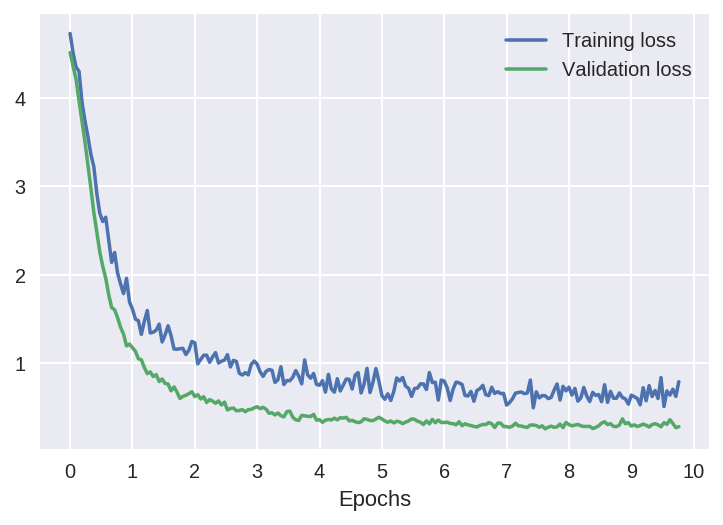

In [23]:
labels = [1,2,3,4,5,6,7,8,9,10]
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epochs')
plt.xticks(locations, ind)
plt.show();

In [62]:
# load the model
state_dict = torch.load('model_flower.pt')
print(state_dict.keys())

odict_keys(['features.conv0.weight', 'features.norm0.weight', 'features.norm0.bias', 'features.norm0.running_mean', 'features.norm0.running_var', 'features.norm0.num_batches_tracked', 'features.denseblock1.denselayer1.norm1.weight', 'features.denseblock1.denselayer1.norm1.bias', 'features.denseblock1.denselayer1.norm1.running_mean', 'features.denseblock1.denselayer1.norm1.running_var', 'features.denseblock1.denselayer1.norm1.num_batches_tracked', 'features.denseblock1.denselayer1.conv1.weight', 'features.denseblock1.denselayer1.norm2.weight', 'features.denseblock1.denselayer1.norm2.bias', 'features.denseblock1.denselayer1.norm2.running_mean', 'features.denseblock1.denselayer1.norm2.running_var', 'features.denseblock1.denselayer1.norm2.num_batches_tracked', 'features.denseblock1.denselayer1.conv2.weight', 'features.denseblock1.denselayer2.norm1.weight', 'features.denseblock1.denselayer2.norm1.bias', 'features.denseblock1.denselayer2.norm1.running_mean', 'features.denseblock1.denselayer2

In [63]:
model.state_dict().keys() == state_dict.keys()

True

In [68]:
model.classifier

Sequential(
  (0): Linear(in_features=1664, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=256, out_features=102, bias=True)
  (4): LogSoftmax()
)

In [74]:
checkpoint = {'models': models.densenet169(pretrained=True),
             'classifier': model.classifier,
             'state_dict': state_dict}

torch.save(checkpoint, 'checkpoint10.pth')

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [0]:
def load_checkpoint(filepath):
  checkpoint = torch.load(filepath)
  model = checkpoint['models']
  model.classifier = checkpoint['classifier']
  model.load_state_dict(checkpoint['state_dict'])
  return model

In [0]:
model_checkpoint = load_checkpoint('checkpoint10.pth')

<class 'torch.Tensor'>
5 11 snapdragon
6 12 colt's foot
101 99 bromelia
73 73 water lily


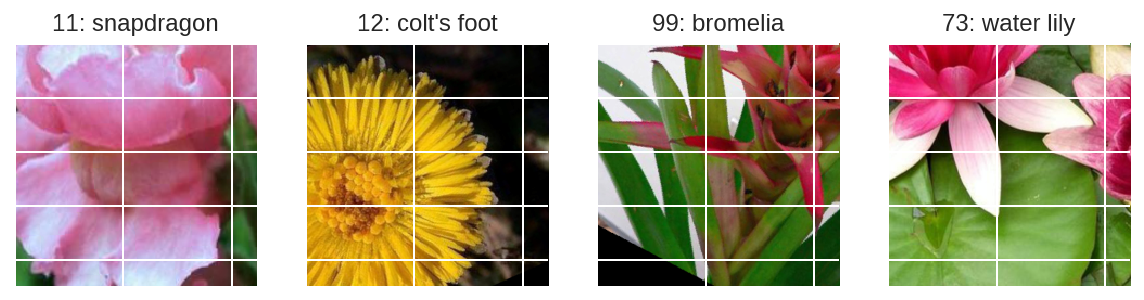

In [108]:
# change this to the trainloader or validloader 
data_iter = iter(trainloader)

images, labels = next(data_iter)
print(type(labels))

# map the labels
new_labels = []
for i in range(len(labels)):
  new_labels.append(int(train_data.classes[labels[i].item()]))
new_labels = torch.tensor(new_labels)
#labels = new_labels
#print(type(labels))
  
fig, axes = plt.subplots(figsize=(10,10), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=True)
    print(labels[ii].item(), new_labels[ii].item(), cat_to_name[str(new_labels[ii].item())])
    ax.set_title("{}: {}".format(new_labels[ii].item(), cat_to_name[str(new_labels[ii].item())]))

In [0]:
model_checkpoint.to('cpu')
model_checkpoint.eval()

with torch.no_grad():
    output = model_checkpoint.forward(images)

In [111]:
# actual mapped label, unmapped label
new_labels[0].item(), labels[0].item()

(11, 5)

In [110]:
ps = torch.exp(output)
images.shape, ps.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 102]))

In [113]:
# separating the actual probability values and the class indices
top_p, top_class = ps.topk(5, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[  5,  74,  72,  40,  86],
        [  6,  48,   2,  44,  47],
        [101,  19,   3,  94,  74],
        [ 73,  35,  78,  37,  98],
        [ 44,  92,  70,   2,  37],
        [  5,  74,  98,  86,   3],
        [ 82,  50,  85,  74,  98],
        [ 55,  85,  53,  76,  29],
        [ 19, 101,  74,   5,  86],
        [ 76,  23,  75,  91,  40]])


In [114]:
new_labels[:10]

tensor([11, 12, 99, 73, 47, 11, 81, 57, 99, 76])

In [115]:
labels[:10]

tensor([  5,   6, 101,  73,  44,   5,  82,  55, 101,  76])

In [69]:
loaded = models.densenet169(pretrained=True) 
# loaded.classifier = nn.Sequential(nn.Linear(1664, 256),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(256, 102),
#                                  nn.LogSoftmax(dim=1))
loaded.classifier = model.classifier

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [70]:
loaded.load_state_dict(state_dict)
loaded.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint 

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes